In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam

In [8]:
df = pd.read_csv("/kaggle/input/peptide-feature-final/final.csv")
df = df.sample(frac=1)

In [10]:
df

,ID,Label,Sequence,hydrophobicity_polar_first,hydrophobicity_polar_20%,hydrophobicity_polar_40%,hydrophobicity_polar_60%,hydrophobicity_polar_80%,hydrophobicity_polar_100%,hydrophobicity_neutral_first,...,solvent_accessibility_intermediate_40%,solvent_accessibility_intermediate_60%,solvent_accessibility_intermediate_80%,solvent_accessibility_intermediate_100%,solvent_accessibility_exposed_first,solvent_accessibility_exposed_20%,solvent_accessibility_exposed_40%,solvent_accessibility_exposed_60%,solvent_accessibility_exposed_80%,solvent_accessibility_exposed_100%
62685,XRJ83666.1,AMP,RGVRPETPVGVCVEPGVDMVVALLAVL,3.703704,14.814815,22.222222,51.851852,66.666667,66.666667,7.407407,...,29.629630,55.555556,70.370370,70.370370,3.703704,14.814815,22.222222,51.851852,66.666667,66.666667
20617,XRJ86437.1,AMP,HRVEEVLDVEVPLGALPEQA,10.000000,20.000000,25.000000,50.000000,90.000000,95.000000,5.000000,...,60.000000,60.000000,85.000000,85.000000,10.000000,20.000000,25.000000,50.000000,90.000000,95.000000
171575,tr|A0A9X3GUW8|A0A9X3GUW8_9SPHN,nAMP,MKIRNSLKSLKDRHRDNRVIRRRGRTYVINKTNRRFKARQG,4.878049,26.829268,41.463415,56.097561,82.926829,97.560976,14.634146,...,21.951220,63.414634,65.853659,78.048780,4.878049,26.829268,41.463415,56.097561,82.926829,97.560976
40535,XRJ85092.1,AMP,MADRLVRLLSAVAQDPGQSIG,14.285714,19.047619,33.333333,66.666667,71.428571,85.714286,9.523810,...,47.619048,76.190476,90.476190,90.476190,14.285714,19.047619,33.333333,66.666667,71.428571,85.714286
122898,tr|A0A2T5PML1|A0A2T5PML1_9PSED,nAMP,MKVRASVKKLCRNCKIIRREGVVRVICSAEPRHKQRQG,5.263158,23.684211,39.473684,63.157895,89.473684,97.368421,13.157895,...,73.684211,81.578947,86.842105,86.842105,5.263158,23.684211,39.473684,63.157895,89.473684,97.368421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82760,XRJ82262.1,AMP,RQGKTFAARLAAAGLILDPHTR,4.545455,9.090909,18.181818,40.909091,81.818182,100.000000,13.636364,...,86.363636,90.909091,95.454545,95.454545,4.545455,9.090909,18.181818,40.909091,81.818182,100.000000
169990,tr|A0A9E3JWZ9|A0A9E3JWZ9_9BURK,nAMP,MMRNRPTTSPIKETIMTWSKPEFIDWRFGFEITLYIANR,7.692308,12.820513,33.333333,64.102564,79.487179,100.000000,15.384615,...,23.076923,41.025641,53.846154,89.743590,7.692308,12.820513,33.333333,64.102564,79.487179,100.000000
181364,tr|J2ZG35|J2ZG35_9ACTO,nAMP,MKVKPSVKKICDKCKVIRRHGNVMVICDNPRHKQRQG,5.405405,24.324324,40.540541,75.675676,89.189189,97.297297,13.513514,...,16.216216,64.864865,81.081081,86.486486,5.405405,24.324324,40.540541,75.675676,89.189189,97.297297
183915,tr|Q2PPG1|Q2PPG1_UNCXX,nAMP,DSSIYDALVRLAQPWSMRMPLVDSNGNFGSPGNDPA,2.777778,27.777778,50.000000,69.444444,91.666667,94.444444,5.555556,...,44.444444,55.555556,83.333333,97.222222,2.777778,27.777778,50.000000,69.444444,91.666667,94.444444


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 62685 to 76983
Columns: 129 entries, ID to solvent_accessibility_exposed_100%
dtypes: float64(126), object(3)
memory usage: 198.4+ MB


In [12]:
df['Label'].value_counts()

Label
AMP     100000
nAMP    100000
Name: count, dtype: int64

In [13]:
df['Label'] = df['Label'].map({'nAMP': 0, 'AMP': 1})
df['Label'].value_counts()

Label
1    100000
0    100000
Name: count, dtype: int64

In [14]:
df = df.drop(['ID','Sequence'], axis=1)

In [16]:
def standardize_and_reshape(df, feature_columns, target_column, timesteps):
    scaler = MinMaxScaler()
    data_features = scaler.fit_transform(df[feature_columns])

    data_target = df[target_column].values

    X = []
    y = []

    for i in range(len(df) - timesteps + 1):
        X.append(data_features[i:i+timesteps])
        y.append(data_target[i+timesteps-1]) 
    X = np.array(X)
    y = np.array(y)

    return X, y, scaler

In [17]:
feature_columns = df.columns.drop('Label').tolist()
target_column = 'Label'
timesteps = 15
X_lstm, y_lstm, scaler = standardize_and_reshape(df, feature_columns, target_column, timesteps)
print(X_lstm.shape)
print(y_lstm.shape) 

(199986, 15, 126)
(199986,)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X_lstm, y_lstm, test_size=0.2, shuffle=False
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(159988, 15, 126) (159988,)
(39998, 15, 126) (39998,)


In [41]:
model = Sequential([
    LSTM(64, activation='tanh',
         kernel_regularizer=l2(1e-4),
         input_shape=(X_train.shape[1], X_train.shape[2]),
         return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='tanh',
         kernel_regularizer=l2(1e-4),
         return_sequences=False),
    Dropout(0.3),
    Dense(1, activation='sigmoid',
          kernel_regularizer=l2(1e-4))
])

In [42]:
model.compile(
    optimizer= 'adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 15, 64)              │          48,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 15, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,345 (239.63 KB)

 Trainable params: 61,345 (239.63 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,  
    restore_best_weights=True,
    verbose=1
)

In [45]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [46]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 38s 16ms/step - accuracy: 0.8569 - loss: 0.3047 - val_accuracy: 0.9746 - val_loss: 0.1021 - learning_rate: 0.0010
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - accuracy: 0.9715 - loss: 0.1073 - val_accuracy: 0.9717 - val_loss: 0.0994 - learning_rate: 0.0010
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - accuracy: 0.9738 - loss: 0.1002 - val_accuracy: 0.9768 - val_loss: 0.0918 - learning_rate: 0.0010
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - accuracy: 0.9751 - loss: 0.0973 - val_accuracy: 0.9763 - val_loss: 0.0925 - learning_rate: 0.0010
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - accuracy: 0.9754 - loss: 0.0926 - val_accuracy: 0.9789 - val_loss: 0.0830 - learning_rate: 0.0010
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - accuracy: 0.9760 - loss: 0.0897 - val_accuracy: 0.9790 - val_loss: 0.0819 - learning_rate: 0.0010
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accura

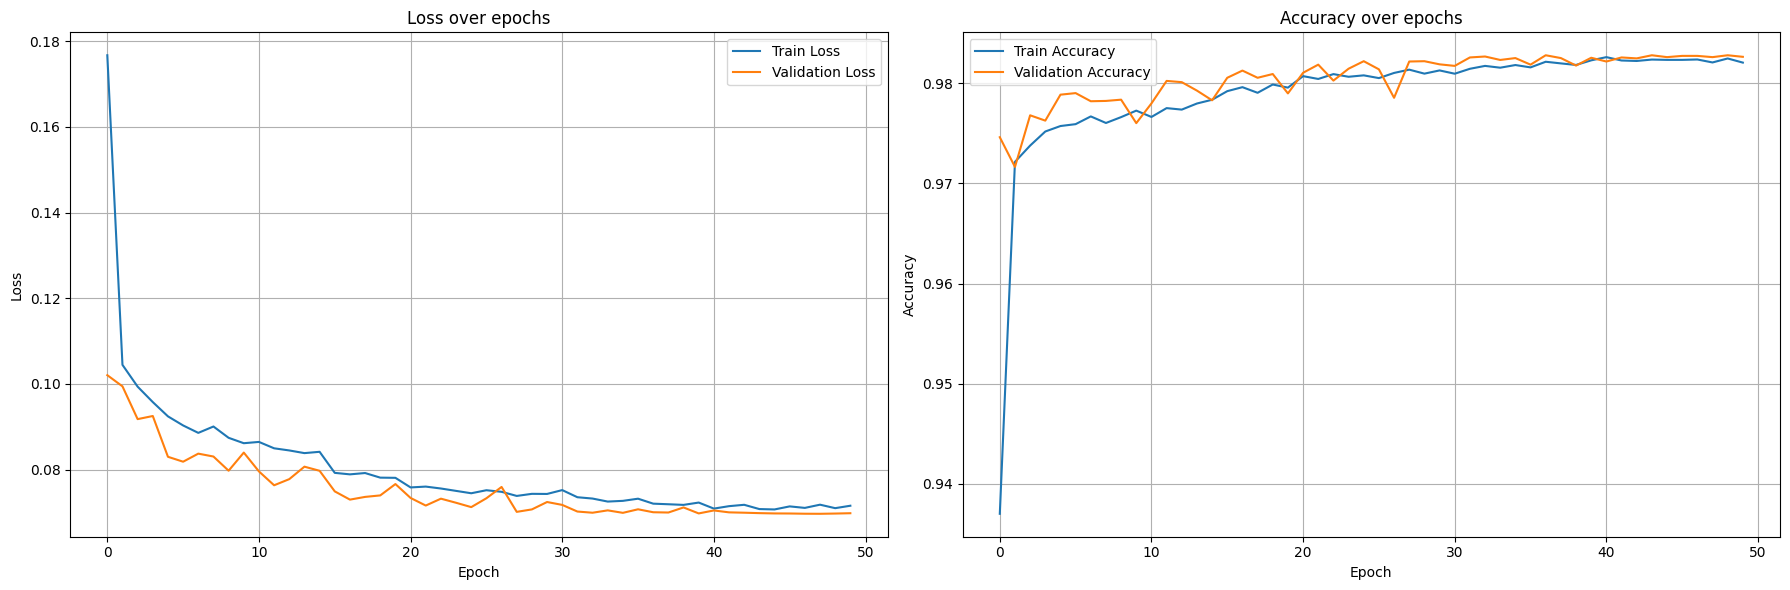

In [47]:
def plot_history_side_by_side(history):
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))  

    axs[0].plot(history.history['loss'], label='Train Loss')
    axs[0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0].set_title('Loss over epochs')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(history.history['accuracy'], label='Train Accuracy')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title('Accuracy over epochs')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_history_side_by_side(history)


In [48]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int) 

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


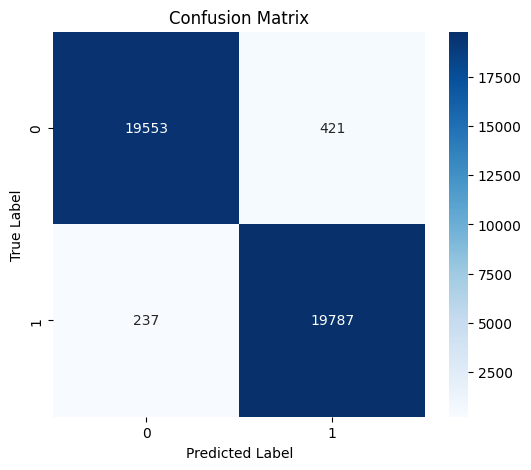

In [49]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     19974
           1       0.98      0.99      0.98     20024

    accuracy                           0.98     39998
   macro avg       0.98      0.98      0.98     39998
weighted avg       0.98      0.98      0.98     39998



In [73]:
model.save('LSTM_294.keras')

### Explainable AI

In [ ]:
def integrated_gradients_multi_samples(model, baseline, samples, steps=50):
    baseline = tf.cast(baseline, tf.float32)
    attributions_list = []

    for sample in samples:
        sample = tf.cast(sample, tf.float32)
        alphas = tf.linspace(0.0, 1.0, steps + 1)

        interpolated_inputs = baseline + alphas[:, tf.newaxis, tf.newaxis] * (sample - baseline)

        with tf.GradientTape() as tape:
            tape.watch(interpolated_inputs)
            preds = model(interpolated_inputs)
        grads = tape.gradient(preds, interpolated_inputs)

        avg_grads = tf.reduce_mean(grads, axis=0)
        integrated_grads = (sample - baseline) * avg_grads
        attributions_list.append(integrated_grads.numpy())

    return np.mean(attributions_list, axis=0) 

In [ ]:
baseline = tf.zeros((15, 126))
num_samples = 1000
samples = tf.convert_to_tensor(X_train[:num_samples])
attributions = integrated_gradients_multi_samples(model, baseline, samples)
feature_importance = np.mean(np.abs(attributions), axis=0)

In [67]:
feature_names = [col for col in df.columns if col != 'Label']

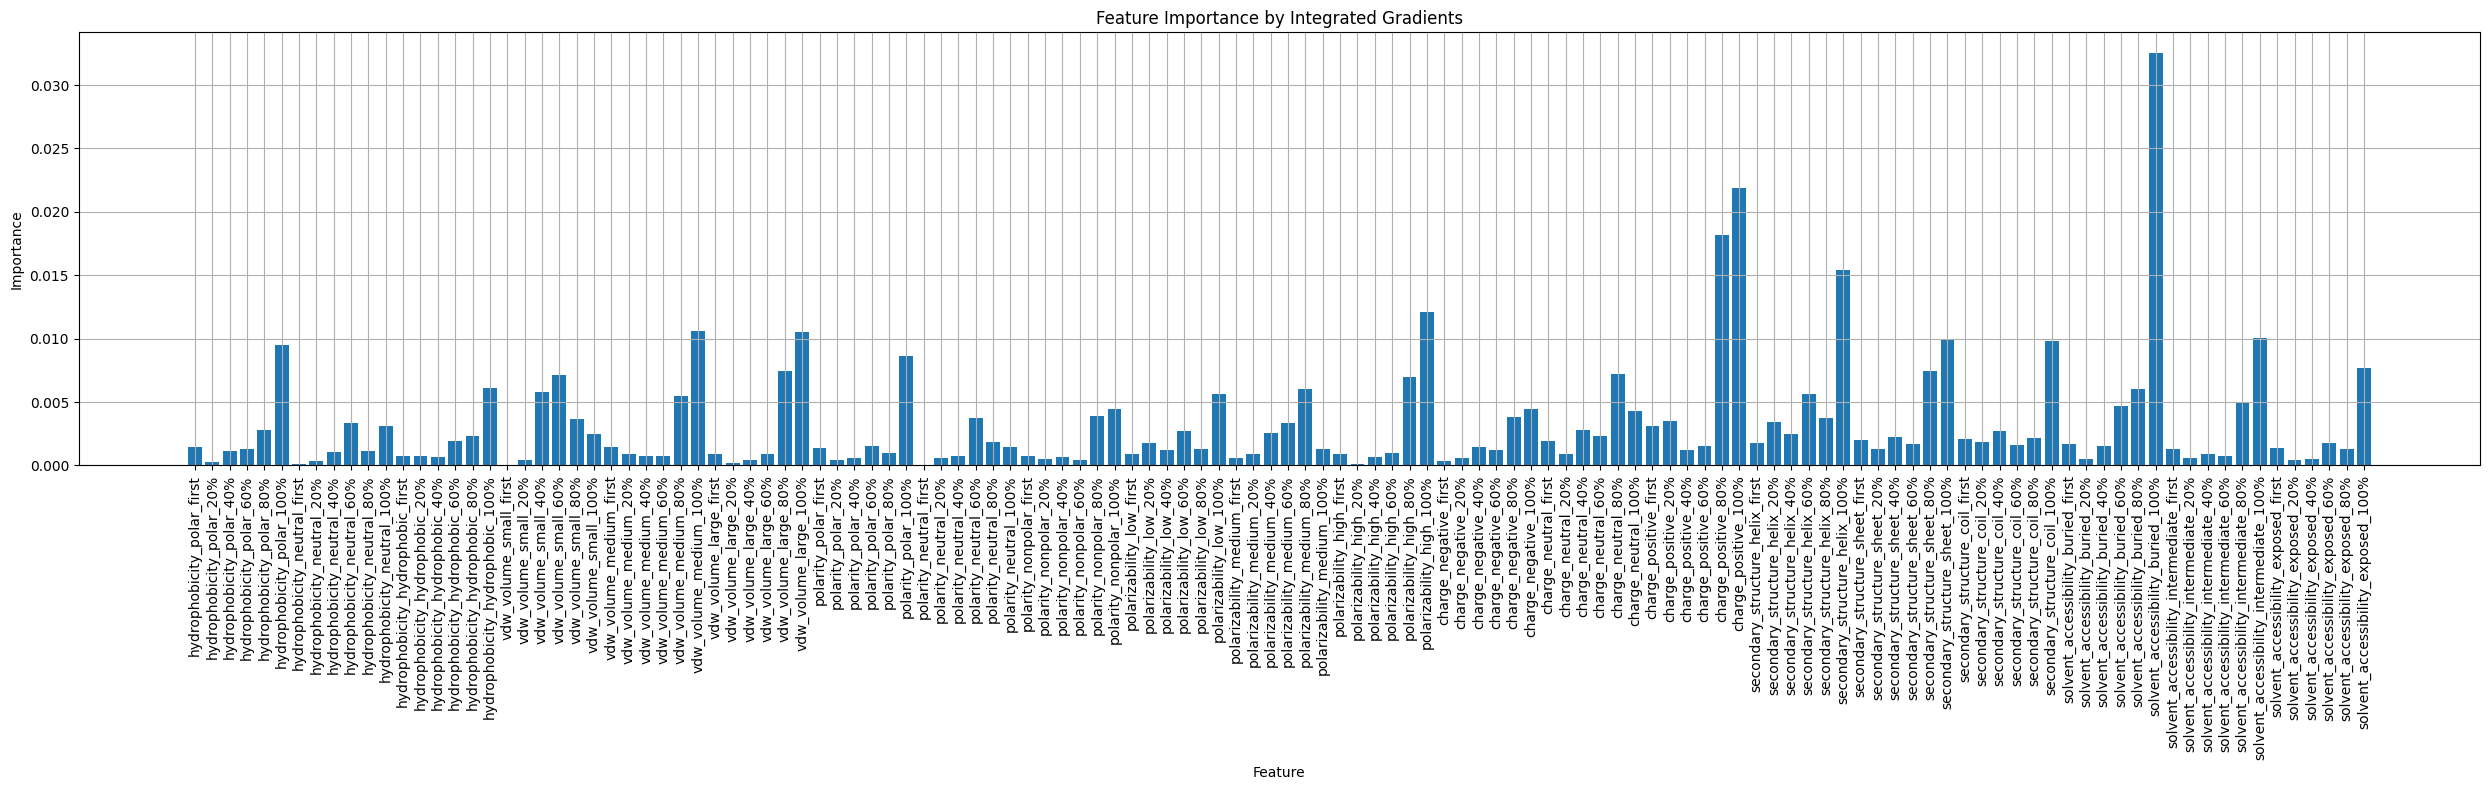

In [68]:
plt.figure(figsize=(25,8))
plt.bar(feature_names, feature_importance)
plt.xticks(rotation=90)  
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance by Integrated Gradients')
plt.grid(True)
plt.tight_layout()
plt.show()

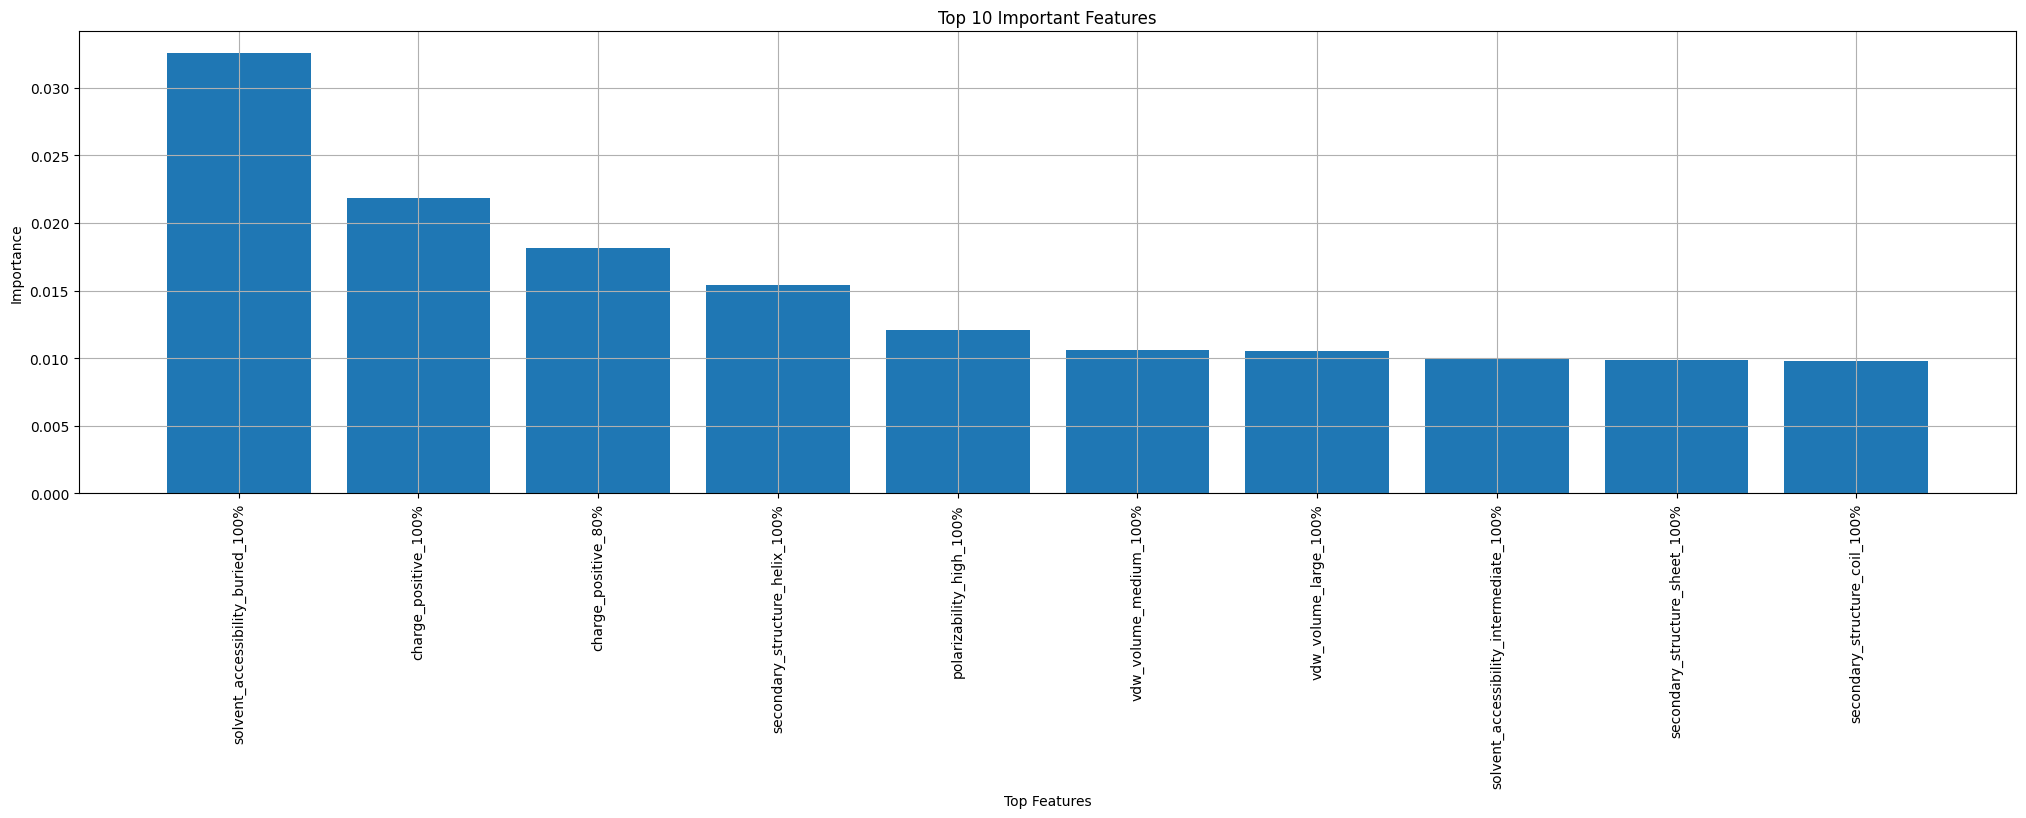

In [72]:
top_idx = np.argsort(feature_importance)[-10:][::-1]  

plt.figure(figsize=(25,6))
plt.bar([feature_names[i] for i in top_idx], feature_importance[top_idx])
plt.xlabel('Top Features')
plt.xticks(rotation=90)  
plt.ylabel('Importance')
plt.title('Top 10 Important Features')
plt.grid(True)
plt.show()